In [1]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from pyomo.gdp import *
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

2022-01-19 12:52:51.268993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 12:52:51.269108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-01-19 12:52:53.381749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 12:52:53.382661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 12:52:53.382939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 12:52:53.383134: W tensorflow/stream_executor/platform/default/dso_loader.c

#  Generate Data


## Training/Testing Data 

#### Create Data 

In [3]:
x = np.linspace(0,4,200) 
y = np.stack([np.array([np.exp(-0.5*x[i])*np.sin(x[i]),np.exp(-0.7*x[i])*np.cos(x[i])]) + np.random.normal(0,0.005,1) for i in range(x.shape[0])],axis = 0)

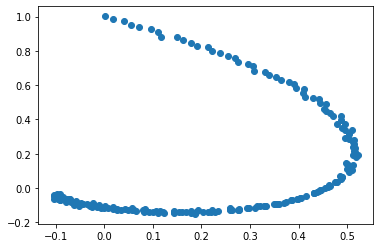

In [4]:
plt.scatter(y[:,0],y[:,1])
plt.show()

#### Safe Bound

In [5]:
poly3 = Polygon([(.45, .1), (.45, .25), (.55, .25), (.55, .1)])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices: A*x <= b
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]  
b = -eqs[0:eqs.shape[0],-1]

In [22]:
print(b)

[-0.45  0.25 -0.1   0.55]


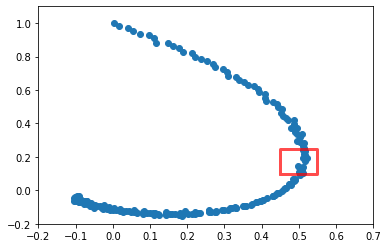

In [6]:
x_poly3, y_poly3 = poly3.exterior.xy
plt.scatter(y[:,0],y[:,1])
plt.plot(x_poly3, y_poly3, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.ylim(-.2,1.1)
plt.xlim(-.2,0.7)
plt.show()

#### Training Mini-Batch Generator

In [7]:
print(x.shape)

(200,)


In [8]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset], self.Y[train_dataset,:], self.X[test_dataset], self.Y[test_dataset,:]
num_pts = x.shape[0]
batch_size = int(0.7 * num_pts)
batch = Batch(x, y, batch_size)

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

#### Initializing Parameters for MLP Model

In [9]:
num_input = 1
num_output = 2
#num_layers_0 = 3
num_hidden_0 = 4
num_hidden_1 = 3
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]
starter_learning_rate = 0.0005
regularizer_rate = 0.01

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(num_input,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))

model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 4)                 8         
_________________________________________________________________
layer1 (Dense)               (None, 3)                 15        
_________________________________________________________________
output (Dense)               (None, 2)                 8         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.9750378 ,  0.95550895, -0.78766644,  0.73672485]],
      dtype=float32)>, <tf.Variable 'layer0/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]
<tf.Variable 'layer0/kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.9750378 ,  0.95550895, -0.78766644,  0.73672485]],
      dt

2022-01-19 12:52:54.004181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Train the model

In [10]:
import tensorflow.keras.backend as kb
#define costum loss function
def keras_SSE_costum(y_actual, y_predicted):
    err = y_actual - y_predicted
    loss_value = kb.sum(kb.square(err))
    return loss_value

In [11]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = keras_SSE_costum,
                   metrics=['accuracy'])
x_train, y_train, x_test, y_test = batch.getBatch()

In [12]:
his = model_orig.fit(x_train, y_train, epochs=10000, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


2022-01-19 12:52:54.227801: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model Accuracy on Test Data Set
2/2 - 0s - loss: 0.1432 - accuracy: 1.0000


[0.1432424634695053, 1.0]

In [13]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()

In [14]:
weights = []
bias = []

for iterate in model_orig.layers:
    print(iterate.output_shape)
    weights.append(iterate.kernel.numpy())
    bias.append(iterate.bias.numpy())





(None, 4)
(None, 3)
(None, 2)


#### Plot Loss Function

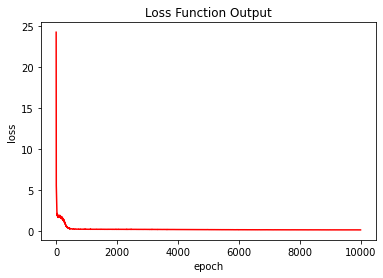

In [15]:

results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Plot Trained Model Ouput

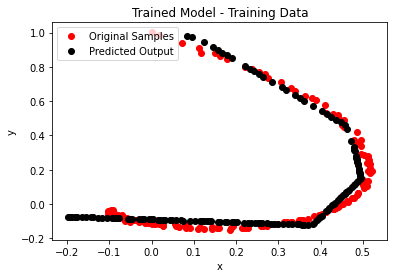

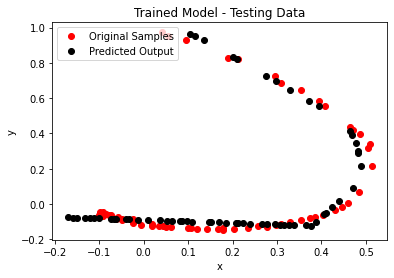

In [16]:
def plot_model(model, x_true, y_true, arg):
    y_predict = model_orig.predict(x_true)
    
    ## training output
    plt.plot(y_true[:,0], y_true[:,1], 'ro', label='Original Samples')

    ## predicted output
    plt.plot(y_predict[:,0], y_predict[:,1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, arg='Trained Model - Testing Data')

In [17]:
# config = model_orig.get_config()
# # print(config)
# # At loading time, register the custom objects with a `custom_object_scope`:
# custom_objects = {"keras_SSE_costum": keras_SSE_costum}
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"keras_SSE_costum": keras_SSE_costum})

In [18]:
model_orig.save('tp', '/home/daittan/NN-Repair')
import pickle

with open("input_output_data.pickle", "wb") as data:
    pickle.dump([x_train, y_train, x_test, y_test], data)

2022-01-19 12:53:31.520818: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tp/assets


In [19]:
from tensorflow import keras
model_tp = keras.models.load_model('/home/daittan/NN-Repair/nn-repair_keyvan/NN-Repair/tp/')



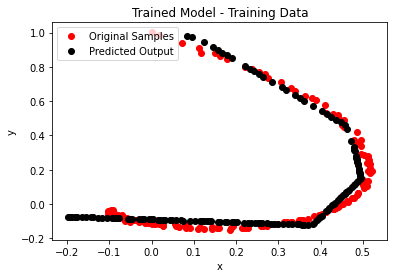

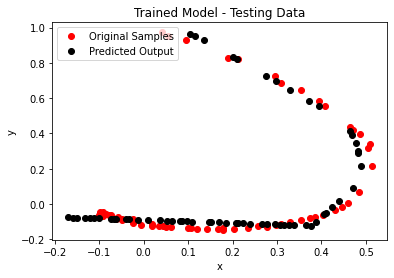

In [20]:

y_predict_train = plot_model(model_tp, x_train, y_train, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_tp, x_test, y_test, arg='Trained Model - Testing Data')